# Projet 8 - Etude de l'impact de l'algorithme Mask R-CNN sur le modèle du projet 7

## Initialisation

#### drive Google

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Librairies

In [0]:
import os
import sys
import math
import random
# import pandas as pd
import numpy as np
import skimage.io
import skimage.transform
# from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt

from shutil import copyfile
# Import joblib functions for save and load
from joblib import dump, load

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.utils.multiclass import unique_labels

# Root directory of the project
# ROOT_DIR = os.path.abspath("../")
ROOT_DIR = r"/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [0]:
from sklearn.metrics import classification_report

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet101
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
  
import h5py

In [0]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
IMAGE_M_DIR = os.path.join(ROOT_DIR, "imagesM")
IMAGE_MB_DIR = os.path.join(ROOT_DIR, "imagesMB")
IMAGE_B_DIR = os.path.join(ROOT_DIR, "imagesB")
IMAGE_R_DIR = os.path.join(ROOT_DIR, "imagesR")
Y_DIR = os.path.join(ROOT_DIR, "annotations")

INPUT_DIRS = [IMAGE_DIR, IMAGE_M_DIR, IMAGE_MB_DIR, IMAGE_B_DIR]

In [0]:
# main_dirs = [IMAGE_M_DIR, IMAGE_MB_DIR, IMAGE_B_DIR]
sub_dirs = ['Train','Val', 'Test']

for main_dir in INPUT_DIRS:
  for sub_dir in sub_dirs:
    dir = os.path.join(main_dir, sub_dir)
    try:
      os.mkdir(dir)
      print("{} créé.".format(dir))
    except FileExistsError:
      print("{} existe déjà.".format(dir))
      pass
try:
  os.mkdir(Y_DIR)
except FileExistsError:
  pass

/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/images/Train créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/images/Val créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/images/Test créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesM/Train créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesM/Val créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesM/Test créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesMB/Train créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesMB/Val créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesMB/Test créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesB/Train créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesB/Val créé.
/content/gdrive/My Drive/Colab Notebooks/P8 - Mask R_CNN/imagesB/Test créé.


In [0]:
NB_RACES = 6

## Création du jeu de Validation

In [0]:
def train_test_function(dirs):
  # on construit liste fichiers et classe correspondante dans deux listes:
  X = []
  y = []
  
  for dir in dirs:
    dir_path = os.path.join(IMAGE_DIR, dir)
    for main_dir in INPUT_DIRS:
      for sub_dir in ['Train', 'Val', 'Test']:
        try:
          os.mkdir(os.path.join(main_dir, sub_dir, dir))
        except FileExistsError:
          pass
    for file in sorted(os.listdir(dir_path)):
      X.append(os.path.join(dir, file))
      y.append(file.split('_')[0]) 

  target_names = list(unique_labels(y))
  y = [target_names.index(x) for x in y]

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=0)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.25,
                                                    random_state=0)

  for img_dir in INPUT_DIRS:
    for x in X_train:
      copyfile(os.path.join(img_dir, x), os.path.join(img_dir, "Train", x))
    for x in X_val:
      copyfile(os.path.join(img_dir, x), os.path.join(img_dir, "Val", x))
    for x in X_test:
      copyfile(os.path.join(img_dir, x), os.path.join(img_dir, "Test", x))
  
  data_filename_memmap = os.path.join(Y_DIR, 'X_train')
  dump(X_train, data_filename_memmap)
  data_filename_memmap = os.path.join(Y_DIR, 'X_val')
  dump(X_val, data_filename_memmap)
  data_filename_memmap = os.path.join(Y_DIR, 'X_test')
  dump(X_test, data_filename_memmap)
  data_filename_memmap = os.path.join(Y_DIR, 'target_names')
  dump(target_names, data_filename_memmap)


In [0]:
# sélectionner NB_RACES répertoires au hasard
l = os.listdir(IMAGE_DIR)
for subfolder in ['Train', 'Val', 'Test']:
  l.remove(subfolder)
race_dirs = random.sample(l, k=NB_RACES)
print(race_dirs)
# On génère les jeux de données
train_test_function(race_dirs)

['n02105641-Old_English_sheepdog', 'n02112018-Pomeranian', 'n02105251-briard']


## Exploration

In [0]:
str_directory = os.path.join(ROOT_DIR, "images/Train")
dirs = sorted(os.listdir(str_directory))
print("il y a {} races à classifier.".format(len(dirs)))

il y a 6 races à classifier.


In [0]:
target_names = []
for dir in dirs: 
  ref, name = (dir.split('-', 1 ))
  target_names.append(name)
print(target_names)

['Rhodesian_ridgeback', 'borzoi', 'briard', 'Old_English_sheepdog', 'Bouvier_des_Flandres', 'Pomeranian']


In [0]:
# cache directory for joblib objects
joblib_path = os.path.join(ROOT_DIR, "joblib_memmap/")
try:
    os.mkdir(joblib_path)
except FileExistsError:
    pass

#### Utilitaires

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = unique_labels(y_true, y_pred)
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(9, 9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.tight_layout()
    return ax

### CNN

#### Bottleneck model

In [0]:
# Train top layer of model
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = os.path.join(ROOT_DIR, 'bottleneck_fc_model.h5')
train_data_dir = os.path.join(IMAGE_M_DIR, 'Train')
validation_data_dir = os.path.join(IMAGE_M_DIR, 'Val')

# nb_train_samples = 5400
# nb_validation_samples = 1440
# epochs = 300
# batch_size = 180

nb_train_samples = 546
nb_validation_samples = 168
epochs = 300
batch_size = 42

In [0]:
def plot_hist(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

Found 607 images belonging to 6 classes.
Found 203 images belonging to 6 classes.
(546, 6)
(168, 6)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 1542      
Total params: 6,490,118
Trainable params: 6,490,118
Non-trainable params: 0
_________________________________________________________________
Train on 546 samples, validate on 168 samples
Epoch 1/300
546/546 [==============================] - 3s 6ms/step - loss: 1.8356 - categorical

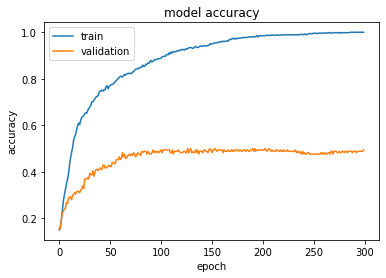

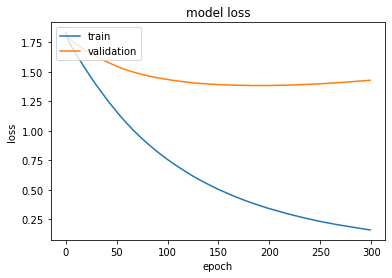

In [0]:
def save_bottleneck_features():
  datagen = ImageDataGenerator(rescale=1. / 255)

  # build the VGG16 network
  model = VGG16(include_top=False, weights='imagenet')

  generator = datagen.flow_from_directory(train_data_dir,
                                          target_size=(img_width, img_height),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)
  bottleneck_features_train = model.predict_generator(generator, 
                                                      nb_train_samples // batch_size)
  # np.save(open(os.path.join(ROOT_DIR, 'bottleneck_features_train.npy'), 'w'),
  #         bottleneck_features_train)

  generator = datagen.flow_from_directory(validation_data_dir,
                                          target_size=(img_width, img_height),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)
  bottleneck_features_validation = model.predict_generator(generator, 
                                                           nb_validation_samples // batch_size,
                                                           max_queue_size = 2)
  # np.save(open(os.path.join(ROOT_DIR, 'bottleneck_features_validation.npy'), 'w'),
  #         bottleneck_features_validation)
  return bottleneck_features_train, bottleneck_features_validation

def train_top_model(train_data, validation_data):
    # train_data = np.load(open(os.path.join(ROOT_DIR, 'bottleneck_features_train.npy')))
    y = []
    for i in range (NB_RACES):
      y +=[i] * (nb_train_samples // NB_RACES)
    train_labels = np.array(OneHotEncoder(handle_unknown='ignore').fit_transform(np.asarray(y).reshape(-1, 1)).toarray())
#   y_feat = OneHotEncoder(handle_unknown='ignore').fit_transform(np.asarray(y).reshape(-1, 1)).toarray()
#   y_feat = np.array(y_feat)
    print(train_labels.shape)
    # validation_data = np.load(open(os.path.join(ROOT_DIR, 'bottleneck_features_validation.npy')))
    y = []
    for i in range (NB_RACES):
      y +=[i] * (nb_validation_samples // NB_RACES)
    validation_labels = np.array(OneHotEncoder(handle_unknown='ignore').fit_transform(np.asarray(y).reshape(-1, 1)).toarray())
    print(validation_labels.shape)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(NB_RACES, activation='softmax'))

    # model.compile(optimizer='rmsprop',
    #               loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy',
                  # optimizer=optimizers.SGD(lr=1e-6, momentum=0.9),
                  optimizer=optimizers.Adam(lr=2e-6, beta_1=0.9, beta_2=0.999, amsgrad=False),
                  metrics=['categorical_accuracy'])
    model.summary()

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              max_queue_size = 2)
    model.save_weights(top_model_weights_path)

    plot_hist(history)

bottleneck_feat_train, bottleneck_feat_validation = save_bottleneck_features()
train_top_model(bottleneck_feat_train, bottleneck_feat_validation)

In [0]:
def init_cnn(nb, img_size):
  """
  This function defines the CNN model corresponding to VGG16 and NB_RACES classes to predict
  returns model"""
  # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
  base_model = VGG16(weights="imagenet",
                     include_top=False,
                     input_shape = img_size)
  
  add_model = Sequential()
  add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  add_model.add(Dense(256, activation='relu'))
  add_model.add(Dense(256, activation='relu'))
  add_model.add(Dropout(0.5))
  add_model.add(Dense(nb, activation='softmax'))

  add_model.load_weights(top_model_weights_path)

  #  add the model on top of the convolutional base
  model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
  
  for l in model.layers[:15]:
    l.trainable = False

  model.compile(loss='categorical_crossentropy', 
                # optimizer=optimizers.SGD(lr=1e-7, momentum=0.9),
                optimizer=optimizers.Adam(lr=2e-6, beta_1=0.9, beta_2=0.999, amsgrad=False),
                metrics=['categorical_accuracy'])
 
  return model

In [0]:
def train_cnn(model, train_data_dir, validation_data_dir, img_width, img_height, batch_size):
  # epochs = 300

  train_datagen = ImageDataGenerator(rotation_range=30,
                                     rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)  
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
                                                    shuffle=True,)
  validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
                                                    shuffle=True,)

  nb_train_samples = train_generator.n
  print("nb train samples: {}".format(nb_train_samples))
  nb_validation_samples = validation_generator.n
  print("nb val samples: {}".format(nb_validation_samples))

  # train_datagen.fit(X_train)
  # fine-tune the model
  history = model.fit_generator(train_generator,
                                steps_per_epoch=nb_train_samples // batch_size +1,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=nb_validation_samples // batch_size +1,
                                callbacks=[ModelCheckpoint(
                                    'VGG16-transferlearning.model',
                                    monitor='val_categorical_accuracy',
                                    save_best_only=True),
#                                            EarlyStopping(monitor='val_categorical_accuracy',
#                                                          min_delta=0.001,
#                                                          patience=10,
#                                                          verbose=0,
#                                                          mode='auto',
#                                                          baseline=None,
#                                                          restore_best_weights=True)
],
                                max_queue_size=2,
                                verbose = 0)
  return history, model

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    plt.figure()
    for (idx, c_label) in enumerate(target_names): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    plt.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

In [0]:
def test_cnn(model, test_data_dir, img_width, img_height, batch_size):
  
  test_datagen = ImageDataGenerator(rescale=1./255)

  test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

  nb_test_samples = test_generator.n

  test_generator.reset()

  #Confution Matrix and Classification Report
  Y_pred = model.predict_generator(test_generator,
                                  #  nb_test_samples // batch_size+1,
                                   verbose = True)
  y_pred = np.argmax(Y_pred, axis=1)
  print('Confusion Matrix')
  print(confusion_matrix(test_generator.classes, y_pred))  
  plot_confusion_matrix(test_generator.classes, y_pred, target_names,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)
  return accuracy_score(test_generator.classes, y_pred)
  # roc_score = multiclass_roc_auc_score(test_generator.classes, y_pred)
  # print('Score roac_auc: {}'.format(roc_score))
  # print('Classification Report')
  # # target_names = ['Cats', 'Dogs', 'Horse']
  # print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [0]:
def modelisation(input_dir, NB_RACES, std_size_cnn, batch_size, target_names):
  
  cnn_model = init_cnn(NB_RACES, std_size_cnn)
  # cnn_model.summary()

  hist, model = train_cnn(cnn_model, os.path.join(input_dir, 'Train'),
                          os.path.join(input_dir, 'Val'),
                          std_size_cnn[0], std_size_cnn[1], batch_size)
  plot_hist(hist)

  cnn_score = test_cnn(model, os.path.join(input_dir, 'Test'), std_size_cnn[0], std_size_cnn[1], batch_size)
  
  # cnn_score = test_cnn(model, os.path.join(input_dir, 'Test'), std_size_cnn[0], std_size_cnn[1], batch_size)

  plt.show()
  return cnn_score

## Modélisation


Images brutes




58892288/58889256 [==============================] - 5s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Found 607 images belonging to 6 classes.
Found 203 images belonging to 6 classes.
nb train samples: 607
nb val samples: 203
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




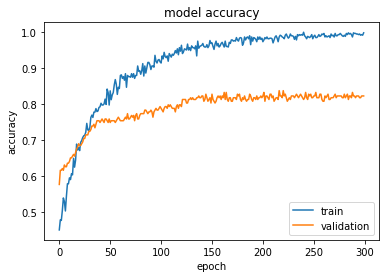

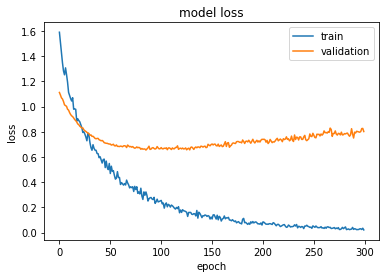

Found 203 images belonging to 6 classes.
5/5 [==============================] - 107s 21s/step
Confusion Matrix
[[35  1  0  1  1  0]
 [ 2 18  1  2  0  1]
 [ 1  1 25  0  2  2]
 [ 0  0  2 27  0  2]
 [ 1  0  6  0 26  0]
 [ 0  1  1  1  1 42]]
Normalized confusion matrix


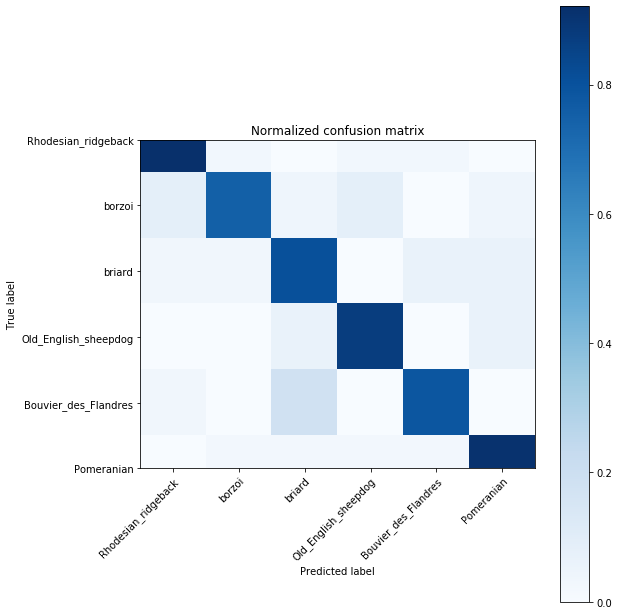

0.8522167487684729

Images avec Box
Found 607 images belonging to 6 classes.
Found 203 images belonging to 6 classes.
nb train samples: 607
nb val samples: 203


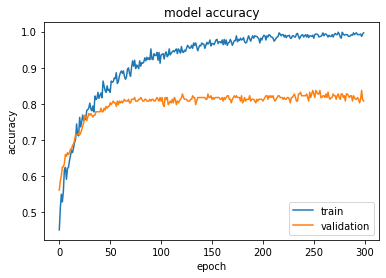

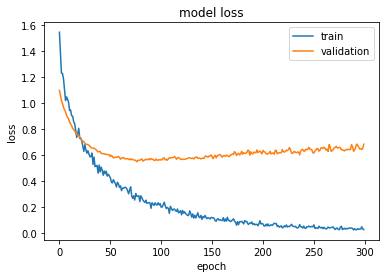

Found 203 images belonging to 6 classes.
5/5 [==============================] - 126s 25s/step
Confusion Matrix
[[38  0  0  0  0  0]
 [ 1 22  1  0  0  0]
 [ 1  0 25  2  3  0]
 [ 0  1  2 26  0  2]
 [ 0  0  4  0 29  0]
 [ 0  1  1  1  0 43]]
Normalized confusion matrix


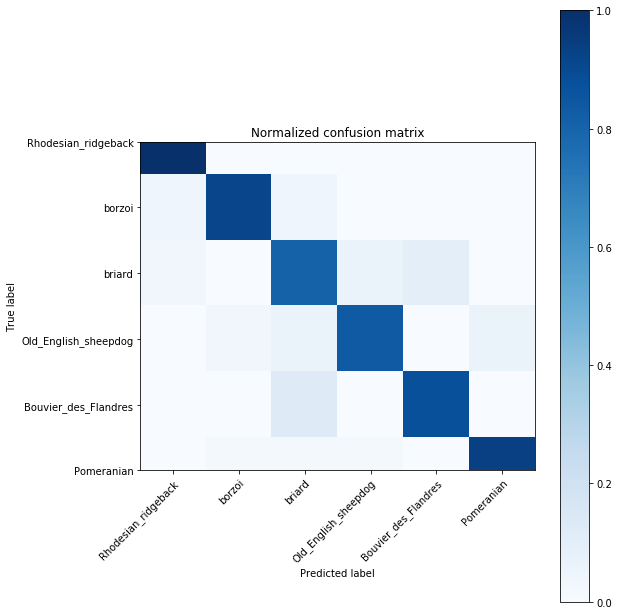

0.9014778325123153

Images avec Mask
Found 607 images belonging to 6 classes.
Found 203 images belonging to 6 classes.
nb train samples: 607
nb val samples: 203


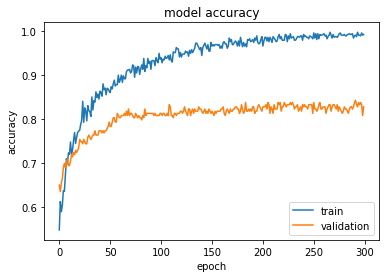

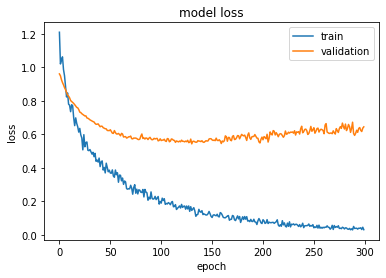

Found 203 images belonging to 6 classes.
5/5 [==============================] - 106s 21s/step
Confusion Matrix
[[36  1  0  0  1  0]
 [ 0 20  2  0  0  2]
 [ 2  0 28  0  0  1]
 [ 0  4  1 24  1  1]
 [ 1  0  5  0 25  2]
 [ 1  0  2  0  1 42]]
Normalized confusion matrix


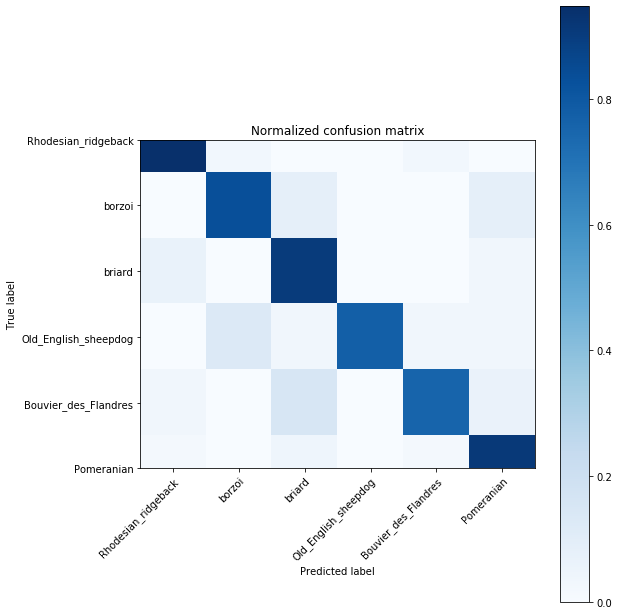

0.8620689655172413

Images avec Mask et Box
Found 607 images belonging to 6 classes.
Found 203 images belonging to 6 classes.
nb train samples: 607
nb val samples: 203


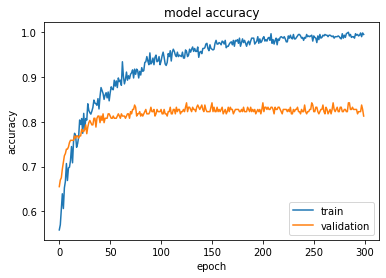

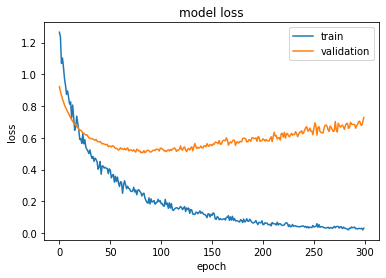

Found 203 images belonging to 6 classes.
5/5 [==============================] - 120s 24s/step
Confusion Matrix
[[36  0  0  0  2  0]
 [ 1 19  3  0  0  1]
 [ 2  0 26  1  2  0]
 [ 0  1  2 26  0  2]
 [ 2  0  5  0 26  0]
 [ 0  0  2  0  0 44]]
Normalized confusion matrix


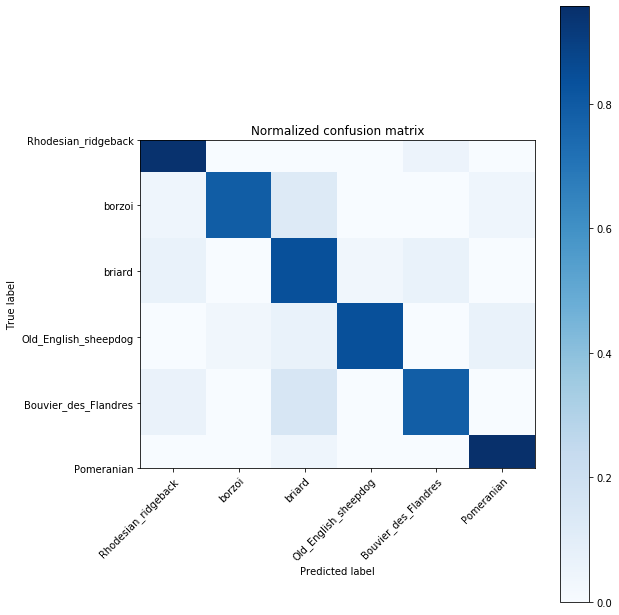

0.8719211822660099


In [0]:
std_size_cnn=(224,224,3)

input_types = {'Images brutes': IMAGE_DIR,
               'Images avec Box':IMAGE_B_DIR,
               'Images avec Mask': IMAGE_M_DIR,
               'Images avec Mask et Box': IMAGE_MB_DIR
               }
results = {}


for input_type in input_types:
  print("\n{}".format(input_type))
  # acc_score = modelisation(input_types[input_type], NB_RACES, std_size_cnn, batch_size, target_names)
  # results[input_type] = acc_score
  acc_score = modelisation(input_types[input_type], NB_RACES, std_size_cnn, batch_size, target_names)
  print(acc_score)
  results[input_type] = acc_score

In [0]:
results

{'Images avec Box': 0.9014778325123153,
 'Images avec Mask': 0.8620689655172413,
 'Images avec Mask et Box': 0.8719211822660099,
 'Images brutes': 0.8522167487684729}